Material refractive indices:
  GaN: 2.39
  Porous GaN: 1.956
  AlGaN: 2.12
  Si: 3.47

=== Building structure from bottom to top ===
1. DBR: 20 layers
   DBR top at y = -1.1382 µm (-1138.2 nm)
2. GaN layer: 670 nm, top at y = -1.8082 µm
3. Graded region: 1700 nm, top at y = -3.5082 µm
4. AlGaN layer: 250 nm, top at y = -3.7582 µm
5. Si substrate: 3000 nm, top at y = -6.7582 µm

Total structure height: 6.76 µm

=== Cell and geometry positioning ===
Cell size: 3.0 x 9.26 µm
Cell range: y ∈ [-4.63, 4.63] µm
Bottom PML: y ∈ [-4.63, -4.13] µm
Geometry center: Vector3<0.0, -0.75, 0.0>
Structure top: y = 2.63 µm
Structure bottom: y = -4.13 µm
Si bottom: y = -4.13 µm
Si intersects PML: False

=== Source and measurement planes ===
Source position: y = 1.00 µm (above structure)
Reflection plane: y = 0.50 µm (above structure, measures upward flux)

Frequency range: 1.429 to 3.333 (1/µm)
Wavelength range: 300 to 700 nm
Gaussian pulse center: 500 nm, width: 1.905 (1/µm)
Stopping criteria: field dec

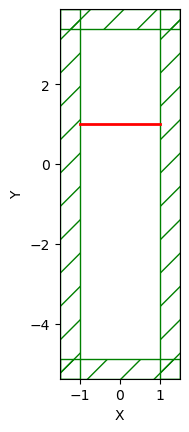

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt


resolution = 180   
res_label = f"{resolution} pix/µm"


porosity = 0.4
n_gan = 2.39
n_porous = (porosity*1 + (1-porosity)*n_gan**2)**0.5
n_algan = 2.12
n_si = 3.47
eps_gan = n_gan**2
eps_porous = n_porous**2
eps_algan = n_algan**2
eps_si = n_si**2

print(f"Material refractive indices:")
print(f"  GaN: {n_gan}")
print(f"  Porous GaN: {n_porous:.3f}")
print(f"  AlGaN: {n_algan}")
print(f"  Si: {n_si}")


thickness_high = 0.05117 
thickness_low = 0.06265   
n_pairs = 5           
n_layers = 10        

# wavelength range: 300 nm to 700 nm
lam_min = 0.3            # µm (300 nm)
lam_max = 0.7            # µm (700 nm)
fmax = 1.0 / lam_min     # = 3.333 (1/µm)
fmin = 1.0 / lam_max     # = 1.429 (1/µm)
fcen = 1/0.5             # center frequency = 2.0 (500 nm)
df = fmax - fmin         # bandwidth


geometry = []
y_bottom = 0.0  

# 1. DBR stack (10 layers)
print(f"\n=== Building structure from bottom to top ===")
print(f"1. DBR: {n_layers} layers")
for i in range(n_layers):
    if i % 2 == 0:  # even indices = GaN
        mat_eps = eps_gan
        layer_thick = thickness_high
    else:           # odd indices = porous GaN
        mat_eps = eps_porous
        layer_thick = thickness_low
    
    y_center = y_bottom - 0.5 * layer_thick
    geometry.append(mp.Block(size=mp.Vector3(mp.inf, layer_thick, mp.inf),
                             center=mp.Vector3(0, y_center, 0),
                             material=mp.Medium(epsilon=mat_eps)))
    y_bottom -= layer_thick

print(f"   DBR top at y = {y_bottom:.4f} µm ({y_bottom*1000:.1f} nm)")

# 2. GaN layer (0.67 µm)
layergan = 0.67
y_center = y_bottom - 0.5 * layergan
geometry.append(mp.Block(size=mp.Vector3(mp.inf, layergan, mp.inf),
                         center=mp.Vector3(0, y_center, 0),
                         material=mp.Medium(epsilon=eps_gan)))
y_bottom -= layergan
print(f"2. GaN layer: {layergan*1000:.0f} nm, top at y = {y_bottom:.4f} µm")

# 3. Graded region (1.7 µm)
grading_height = 1.7
epsilon_bottom = (0.75*n_algan**2 + 0.25*n_gan**2)
epsilon_top = (0.26*n_algan**2 + 0.74*n_gan**2)
grading_center_y = y_bottom - 0.5 * grading_height

def graded_y_func(p):
    y_min = grading_center_y - grading_height / 2
    y_max = grading_center_y + grading_height / 2
    
    if y_min <= p.y <= y_max:
        normalized_y = (p.y - y_min) / grading_height
        eps = epsilon_bottom + (epsilon_top - epsilon_bottom) * normalized_y
        return mp.Medium(epsilon=eps)
    elif p.y < y_min:
        return mp.Medium(epsilon=epsilon_bottom)
    else:
        return mp.Medium(epsilon=epsilon_top)

geometry.append(mp.Block(
    center=mp.Vector3(0, grading_center_y, 0),
    size=mp.Vector3(mp.inf, grading_height, mp.inf),
    material=graded_y_func
))
y_bottom -= grading_height
print(f"3. Graded region: {grading_height*1000:.0f} nm, top at y = {y_bottom:.4f} µm")

# 4. AlGaN layer (250 nm)
layeralgan = 0.25
y_center = y_bottom - 0.5 * layeralgan
geometry.append(mp.Block(size=mp.Vector3(mp.inf, layeralgan, mp.inf),
                         center=mp.Vector3(0, y_center, 0),
                         material=mp.Medium(epsilon=eps_algan)))
y_bottom -= layeralgan
print(f"4. AlGaN layer: {layeralgan*1000:.0f} nm, top at y = {y_bottom:.4f} µm")

# 5. Si substrate (2 µm)
layersi = 3
y_center = y_bottom - 0.5 * layersi
geometry.append(mp.Block(size=mp.Vector3(mp.inf, layersi, mp.inf),
                         center=mp.Vector3(0, y_center, 0),
                         material=mp.Medium(epsilon=eps_si)))
y_bottom -= layersi
print(f"5. Si substrate: {layersi*1000:.0f} nm, top at y = {y_bottom:.4f} µm")

total_structure_height = -y_bottom
print(f"\nTotal structure height: {total_structure_height:.2f} µm")

# Cell dimensions and positioning
sx = 3.0
dpml = 0.5  # PML thickness



src_y = 1.0
refl_y = 0.5



top_space = src_y + dpml + 0.5  
bottom_space = 0.5 

sy = top_space + total_structure_height + bottom_space


geometry_center_y = -(total_structure_height/2) + (sy/2) - top_space

cell = mp.Vector3(sx, sy, 0)
shifted_origin = mp.Vector3(0, geometry_center_y, 0)
pml_layers = [mp.PML(dpml)]


cell_bottom = -sy/2
cell_top = sy/2
pml_bottom_start = cell_bottom
pml_bottom_end = cell_bottom + dpml
structure_bottom = geometry_center_y - total_structure_height/2
structure_top = geometry_center_y + total_structure_height/2
si_bottom = structure_bottom

print(f"\n=== Cell and geometry positioning ===")
print(f"Cell size: {sx} x {sy:.2f} µm")
print(f"Cell range: y ∈ [{cell_bottom:.2f}, {cell_top:.2f}] µm")
print(f"Bottom PML: y ∈ [{pml_bottom_start:.2f}, {pml_bottom_end:.2f}] µm")
print(f"Geometry center: {shifted_origin}")
print(f"Structure top: y = {structure_top:.2f} µm")
print(f"Structure bottom: y = {structure_bottom:.2f} µm")
print(f"Si bottom: y = {si_bottom:.2f} µm")
print(f"Si intersects PML: {si_bottom < pml_bottom_end}")

print(f"\n=== Source and measurement planes ===")
print(f"Source position: y = {src_y:.2f} µm (above structure)")
print(f"Reflection plane: y = {refl_y:.2f} µm (above structure, measures upward flux)")

# Source 
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(0, src_y, 0),
                     size=mp.Vector3(sx-2*dpml, 0, 0))]

nfreq = 500


refl_fr = mp.FluxRegion(center=mp.Vector3(0, refl_y, 0), 
                        size=mp.Vector3(sx-2*dpml, 0, 0))

# Probe point for field decay - at reflection plane
pt = mp.Vector3(0, refl_y, 0)

# Simulation stopping criteria
stop_time = 100      
decay_threshold = 1e-3  

print(f"\nFrequency range: {fmin:.3f} to {fmax:.3f} (1/µm)")
print(f"Wavelength range: {lam_min*1e3:.0f} to {lam_max*1e3:.0f} nm")
print(f"Gaussian pulse center: {1/fcen*1e3:.0f} nm, width: {df:.3f} (1/µm)")
print(f"Stopping criteria: field decay to {decay_threshold} after source turns off")
print("\n" + "="*50)
print("Starting simulation setup...")
print("="*50)


sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry_center=shifted_origin,
                    sources=sources,
                    resolution=resolution)

# Plot the structure
plt.figure(dpi=100)
sim.plot2D()
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000491858 s
Working in 2D dimensions.
Computational cell is 3 x 8.68889 x 0 with resolution 180
time for set_epsilon = 0.077029 s
-----------
on time step 659 (time=1.83056), 0.00607756 s/step
on time step 1369 (time=3.80278), 0.00564158 s/step
on time step 2047 (time=5.68611), 0.00590786 s/step
on time step 2733 (time=7.59167), 0.00583146 s/step
on time step 3427 (time=9.51944), 0.00576996 s/step
on time step 4119 (time=11.4417), 0.00578635 s/step
on time step 4822 (time=13.3944), 0.00569369 s/step
on time step 5647 (time=15.6861), 0.00485433 s/step
on time step 6353 (time=17.6472), 0.00566597 s/step
on time step 6983 (time=19.3972), 0.00635106 s/step
on time step 7690 (time=21.3611), 0.00565801 s/step
on time step 8391 (time=23.3083), 0.00570733 s/step
on time step 9101 (time=25.2806), 0.00563726 s/step
on time step 9803 (time=27.2306), 0.0057018 s/step
on time step 10503 (time=29.175), 0.00571518 s/step
on time 

field decay(t = 200.00555555555556): 1.3272754101433575e-13 / 0.2923195863190417 = 4.54049428181234e-13
run 0 finished at t = 200.00555555555556 (72002 timesteps)
Normalization run complete.

Starting full structure simulation...
     block, center = (0,-0.025585,0)
          size (1e+20,0.05117,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.7121,5.7121,5.7121)
     block, center = (0,-0.082495,0)
          size (1e+20,0.06265,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.82726,3.82726,3.82726)
     block, center = (0,-0.139405,0)
          size (1e+20,0.05117,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.7121,5.7121,5.7121)
     block, center = (0,-0.196315,0)
          size (1e+20,0.06265,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.82726,3.82726,3.82726)
     block, cent

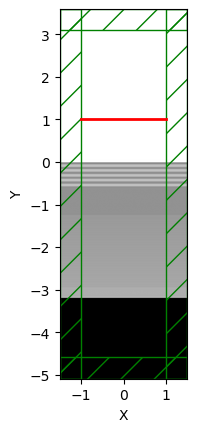

-----------
Initializing structure...
time for choose_chunkdivision = 0.000637054 s
Working in 2D dimensions.
Computational cell is 3 x 8.68889 x 0 with resolution 180
     block, center = (0,-0.025585,0)
          size (1e+20,0.05117,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.7121,5.7121,5.7121)
     block, center = (0,-0.082495,0)
          size (1e+20,0.06265,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.82726,3.82726,3.82726)
     block, center = (0,-0.139405,0)
          size (1e+20,0.05117,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.7121,5.7121,5.7121)
     block, center = (0,-0.196315,0)
          size (1e+20,0.06265,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.82726,3.82726,3.82726)
     block, center = (0,-0.253225,0)
          size (1e+20,0.05117,1e+20)
    

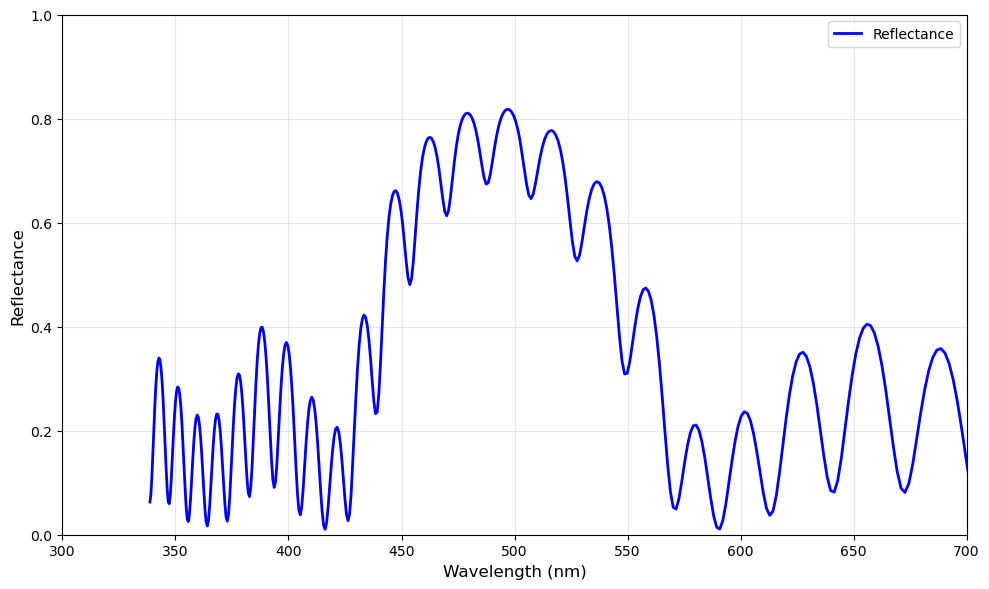


RESULTS

Reflectance at key wavelengths:
  λ = 400.3 nm: R = 0.3476
  λ = 449.8 nm: R = 0.6228
  λ = 499.5 nm: R = 0.8063
  λ = 549.8 nm: R = 0.3104
  λ = 600.2 nm: R = 0.2280

Peak reflectance: R = 0.8178 at λ = 496.7 nm
Min reflectance:  R = 0.0104 at λ = 416.2 nm

✓ All reflectance values are physical (0 ≤ R ≤ 1)


In [ ]:
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

sim.run(until_after_sources=mp.stop_when_fields_decayed(stop_time, mp.Ez, pt, decay_threshold))

straight_refl_data = sim.get_flux_data(refl)
# Get incident flux for normalization (from reflection plane in free space run)
incident_flux = np.array(mp.get_fluxes(refl))

print("Normalization run complete.")
print("\n" + "="*50)
print("Starting full structure simulation...")
print("="*50)

sim.reset_meep()

# run with full geometry
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    geometry_center=shifted_origin,
                    sources=sources,
                    resolution=resolution)

%matplotlib inline
plt.figure(dpi=100)
sim.plot2D()
plt.show()

refl = sim.add_flux(fcen, df, nfreq, refl_fr)

sim.load_minus_flux_data(refl, straight_refl_data)

sim.run(until_after_sources=mp.stop_when_fields_decayed(stop_time, mp.Ez, pt, decay_threshold))

dbr_refl_flux = np.array(mp.get_fluxes(refl))
freqs = np.array(mp.get_flux_freqs(refl))

print("Full structure simulation complete.")

# Compute reflectance
wls = 1.0 / freqs  # wavelengths in µm

R = -dbr_refl_flux / incident_flux  

# Plotting
if mp.am_master():
    plt.figure(figsize=(10, 6))
    plt.plot(wls*1e3, R, 'b-', label='Reflectance', linewidth=2)
    plt.xlabel('Wavelength (nm)', fontsize=12)
    plt.ylabel('Reflectance', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.xlim(300, 700)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('structure_reflectance.png', dpi=150)
    plt.show()
    
    # Diagnostics
    print(f"\n{'='*50}")
    print("RESULTS")
    print(f"{'='*50}")
    print(f"\nReflectance at key wavelengths:")
    for target_wl in [400, 450, 500, 550, 600]:
        idx = np.argmin(np.abs(wls*1e3 - target_wl))
        actual_wl = wls[idx]*1e3
        print(f"  λ = {actual_wl:.1f} nm: R = {R[idx]:.4f}")
    
    max_R_idx = np.argmax(R)
    min_R_idx = np.argmin(R)
    print(f"\nPeak reflectance: R = {R[max_R_idx]:.4f} at λ = {wls[max_R_idx]*1e3:.1f} nm")
    print(f"Min reflectance:  R = {R[min_R_idx]:.4f} at λ = {wls[min_R_idx]*1e3:.1f} nm")
    
    # Check for unphysical results
    if np.any(R > 1.0) or np.any(R < -0.01):
        print("\n⚠️  WARNING: Unphysical reflectance values detected!")
        print(f"   Max R = {np.max(R):.4f}, Min R = {np.min(R):.4f}")
    else:
        print("\n✓ All reflectance values are physical (0 ≤ R ≤ 1)")